In [1]:
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import csv
import os
from pylab import *
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

%matplotlib inline

which_data = 'Data_2017_DES_I235E'

In [2]:
(Traffic,Weather,data) = pickle.load( open(which_data+".p", "rb" ) )
year =  data['y'][0][:4]

In [3]:
def monthly_plot(month,dayend,day1='01',data=data,Traffic=Traffic):
    date1 = datetime.datetime.strptime(year+month+day1, '%Y%m%d')
    dateend = datetime.datetime.strptime(year+month+dayend, '%Y%m%d')

    calendar1 = date1.isocalendar()
    calendarend = dateend.isocalendar()

    first_week_in_month = calendar1[1]%53
    year_calendar = calendar1[0]
    if year_calendar<int(year):
        first_week_in_month = 0
    weeks_in_month = calendarend[1] - first_week_in_month + 1
    print('weeks_in_month: ',weeks_in_month)
    gs = gridspec.GridSpec(weeks_in_month, 7, wspace=0.2, hspace=0.2)
    fig = plt.figure(figsize=(21,2*weeks_in_month))


    for day in range(int(day1),int(dayend)+1):
        daystr = ''
        for _ in range(2-len(str(day))):
            daystr += '0'
        daystr += str(day)

        date = datetime.datetime.strptime(year+month+daystr, '%Y%m%d')
        calendar = date.isocalendar()
        week_of_year = calendar[1]
        year_calendar = calendar[0]
        if year_calendar<int(year):
            week_of_year = 0
        
        day_of_week = calendar[2]-1
        row_pos = week_of_year - first_week_in_month
        column_pos = day_of_week
        ax = plt.subplot(gs[row_pos,column_pos])
        ax.set_title(year+month+daystr)
        ax.set_xticks([])
        ax.set_yticks([])
        query = data.index[(data['weekofyear'] == week_of_year) & (data['dayofweek'] == day_of_week)].tolist()
        if len(query)>0:
            index = query[0]
            plt.pcolor(Traffic[index,:,:,0],cmap=my_cmap, vmin=20, vmax=70)
    return fig

In [4]:
# '''Annual speed heatmap plot'''

# month = ['01','02','03','04','05','06','07','08','09','10','11','12']
# dayend =['31','28','31','30','31','30','31','31','30','31','30','31']
# if int(year)%4 == 0:
#     dayend =['31','29','31','30','31','30','31','31','30','31','30','31']
    
# for i in range(12):
#     fig = monthly_plot(month[i],dayend[i])
#     fig.savefig('../data/'+year+'/'+month[i]+'.png')

# from fpdf import FPDF
# pdf = FPDF()
# # imagelist is the list with all image filenames
# imagelist = os.listdir('../data/'+year)
# for image in imagelist:
#     pdf.add_page(orientation = 'L')
#     pdf.image('../data/'+year+'/'+image,-30,0,350,180)
# pdf.output('../data/'+year+'.pdf', "F")

### Data Smoothing

In [5]:
def replace_nan_with_local_mean(M_3d):
    index = np.asarray(np.where(np.isnan(M_3d)))
    for i in range(index.shape[1]):
        span = 0
        historical = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
        historical_mean = np.nanmean(historical)
        stage_1_flag = True
        while (not historical_mean>0) & stage_1_flag:

            if index[0,i]-span<0:
                historical = M_3d[0:index[0,i]+1+span+span,index[1,i],index[2,i]]
            elif index[0,i]+1+span>M_3d.shape[0]:
                historical = M_3d[-1-span-span:,index[1,i],index[2,i]]
            else:
                historical = M_3d[index[0,i]-span:index[0,i]+1+span,index[1,i],index[2,i]]
            historical_mean = np.nanmean(historical)
            span+=1
            if 2*span>M_3d.shape[0]:
                stage_1_flag = False
        span = 0
        while not historical_mean>0:
            if index[2,i]-span<0:
                historical = M_3d[:,index[1,i],0:index[2,i]+1+span+span]
            elif index[2,i]+1+span>M_3d.shape[2]:
                historical = M_3d[:,index[1,i],-1-span-span:]
            else:
                historical = M_3d[:,index[1,i],index[2,i]-span:index[2,i]+1+span]
            historical_mean = np.nanmean(historical)
            span+=1
#         print(historical_mean)

        span = 0
        local = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
        local_mean = np.nanmean(local)
        stage_1_flag = True
        while (not local_mean>0) & stage_1_flag:
            if index[2,i]-span<0:
                local = M_3d[index[0,i],index[1,i],0:index[2,i]+1+span+span]
            elif index[2,i]+1+span>M_3d.shape[2]:
                local = M_3d[index[0,i],index[1,i],-1-span-span:]
            else:
                local = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
            local_mean = np.nanmean(local)
            span+=1
            if 2*span>M_3d.shape[2]:
                stage_1_flag = False
        
        span = 0
        while not local_mean>0:
            if index[1,i]-span<0:
                local = M_3d[index[0,i],0:index[1,i]+1+span+span,:]
            elif index[1,i]+1+span>M_3d.shape[1]:
                local = M_3d[index[0,i],-1-span-span:,:]
            else:
                local = M_3d[index[0,i],index[1,i]-span:index[1,i]+1+span,:]
            local_mean = np.nanmean(local)
            span+=1
        
#         print(local_mean)
        M_3d[index[0,i],index[1,i],index[2,i]] = 0.7*local_mean + 0.3*historical_mean
    return M_3d

In [6]:
def volume_smoothing(Volume,top_threshold = 400):
    Volume[Volume>top_threshold] = nan
    Volume = replace_nan_with_local_mean(Volume)
    return Volume

In [7]:
def speed_smoothing(Speed,top_threshold = 120):
    Speed[Speed>top_threshold] = nan
    Speed = replace_nan_with_local_mean(Speed)
    Speed[Speed == 0] = nan
    Speed = replace_nan_with_local_mean(Speed)
    return Speed

In [8]:
Traffic[:,:,:,0] = speed_smoothing(Traffic[:,:,:,0])
Traffic[:,:,:,1] = volume_smoothing(Traffic[:,:,:,1])

/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/shuo/anaconda2/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


weeks_in_month:  6
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  6
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  6
weeks_in_month:  5
weeks_in_month:  5


''

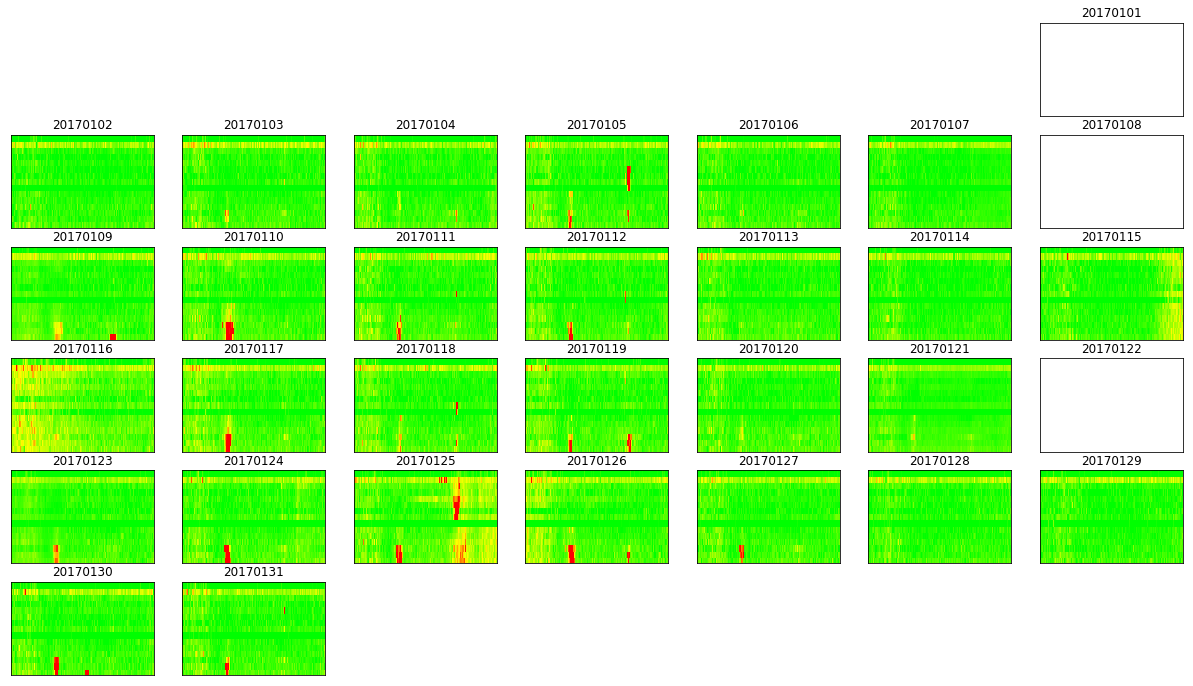

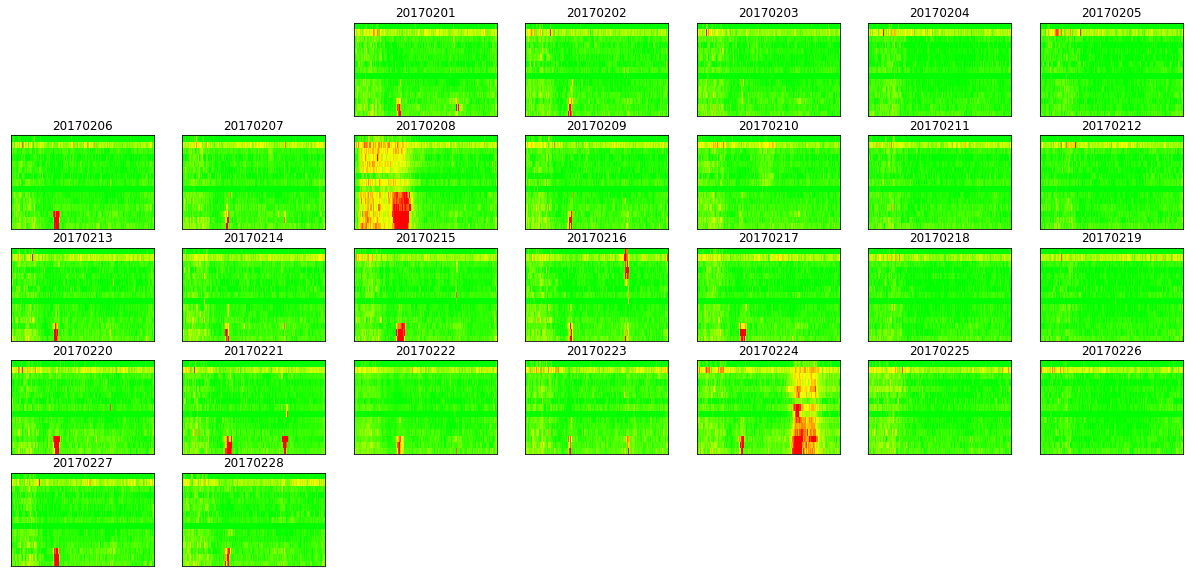

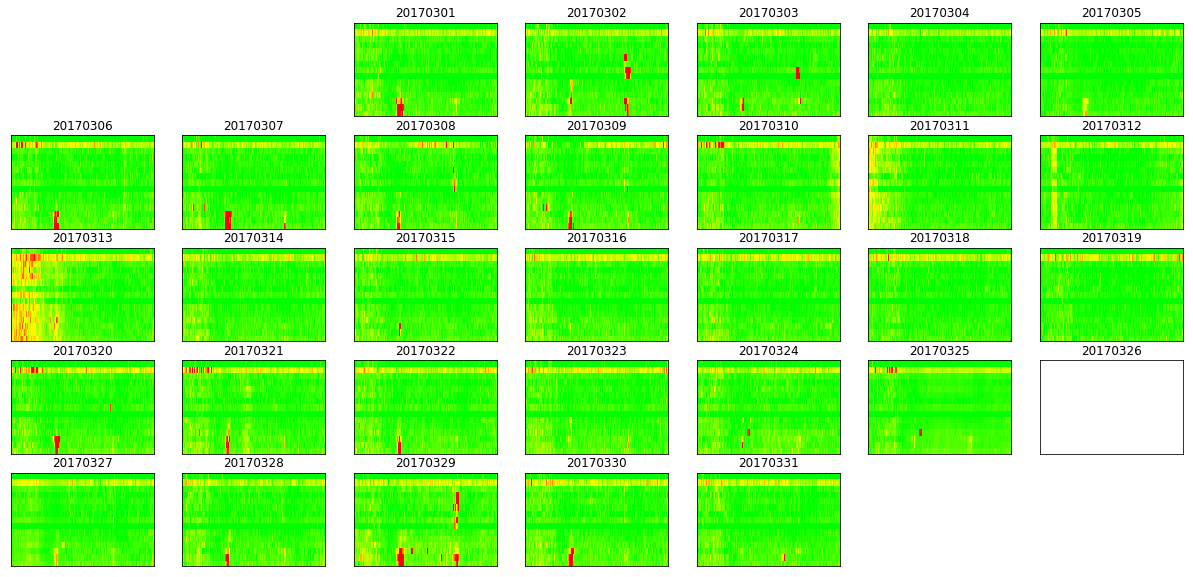

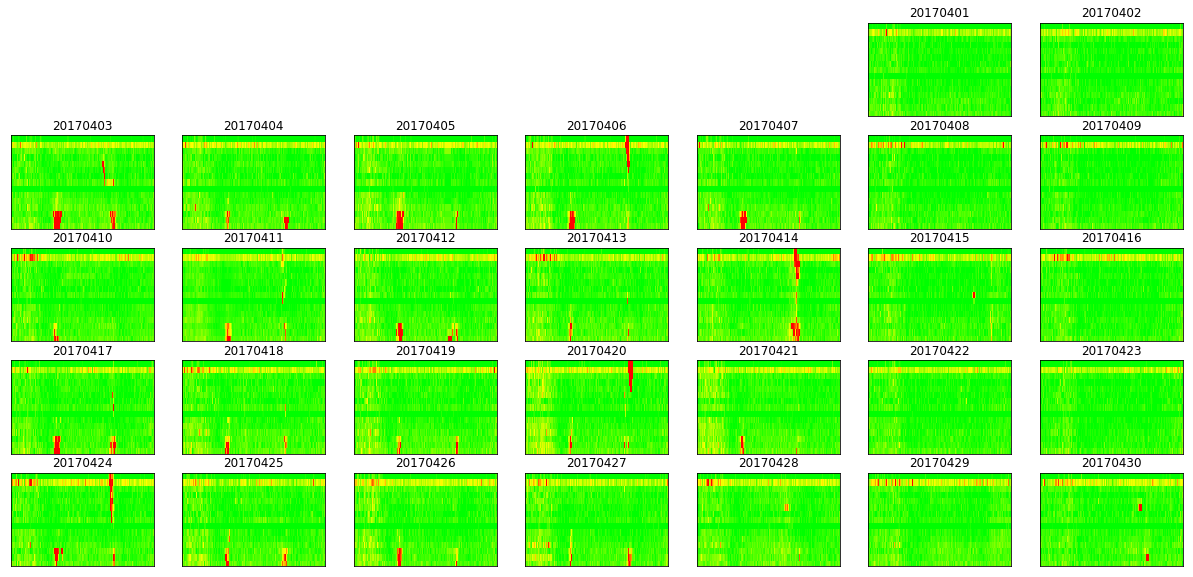

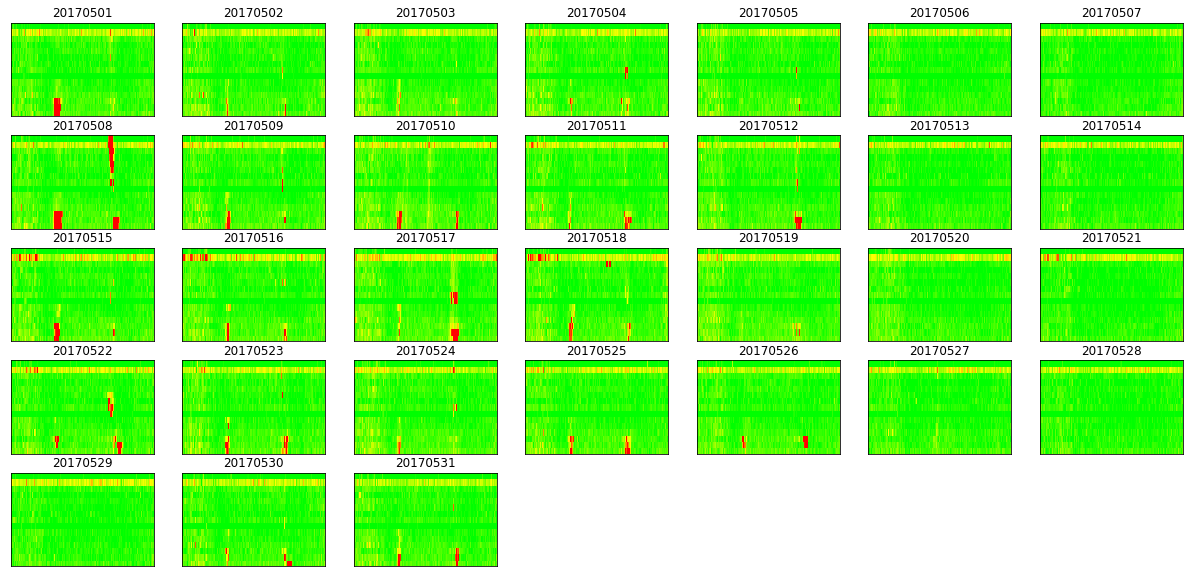

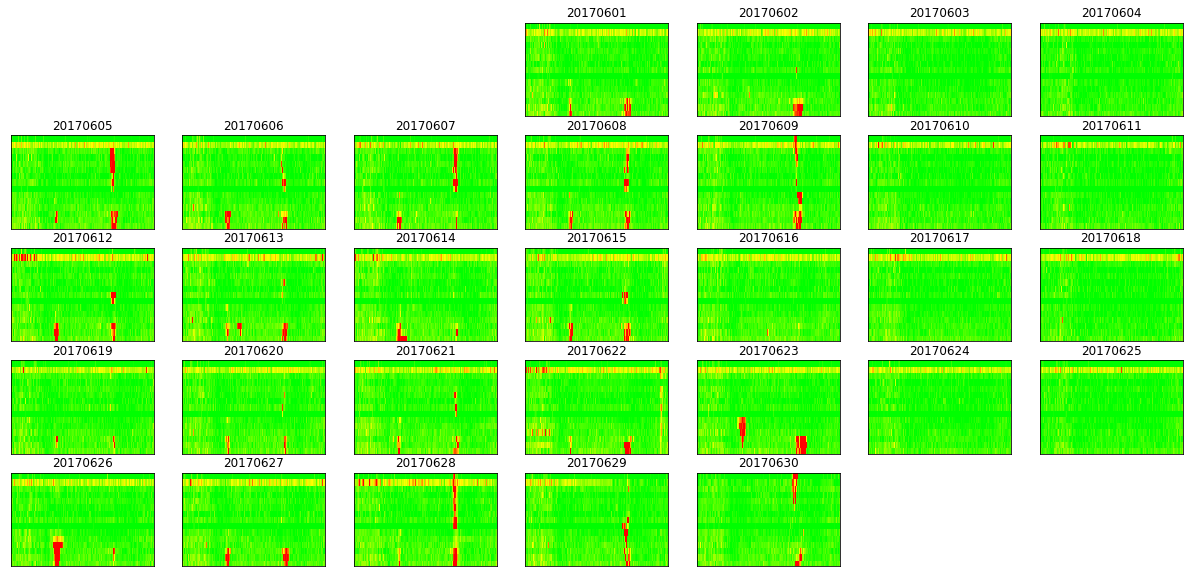

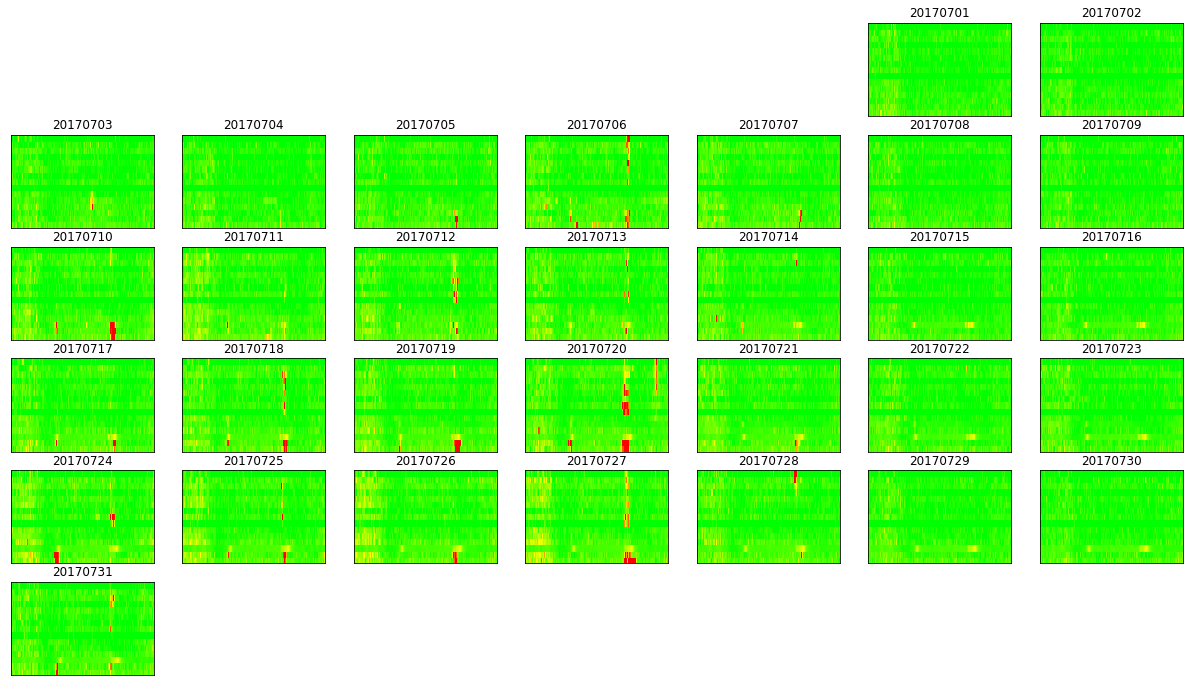

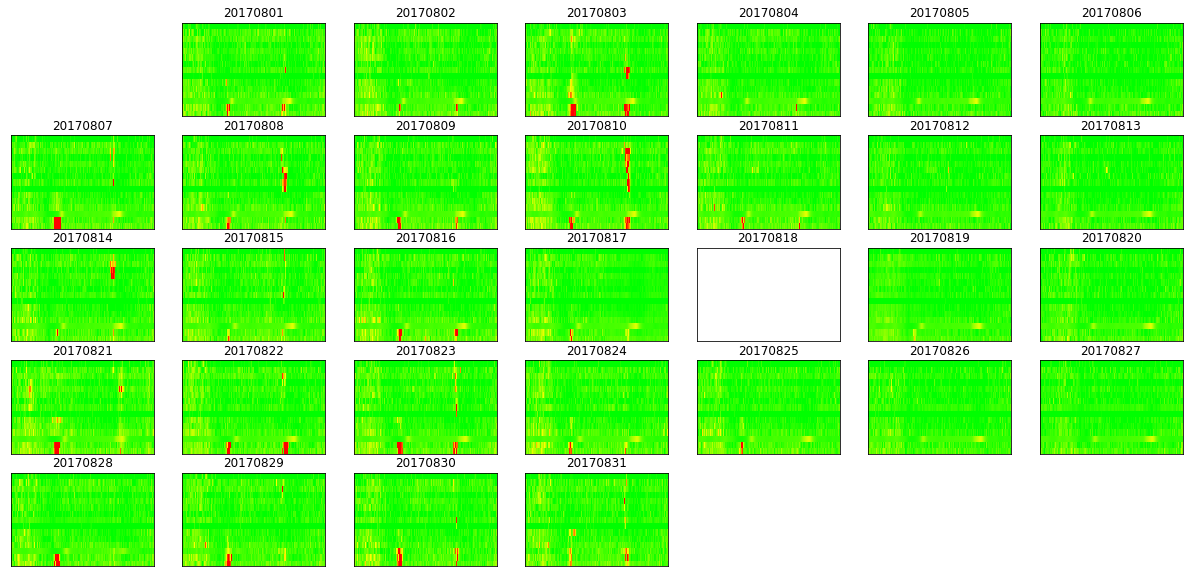

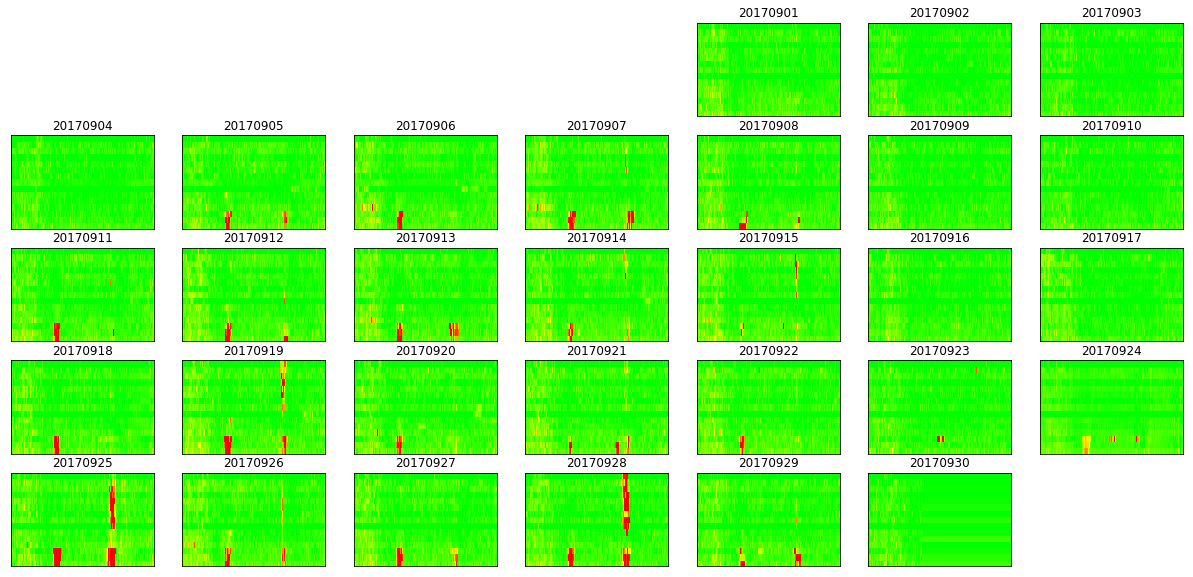

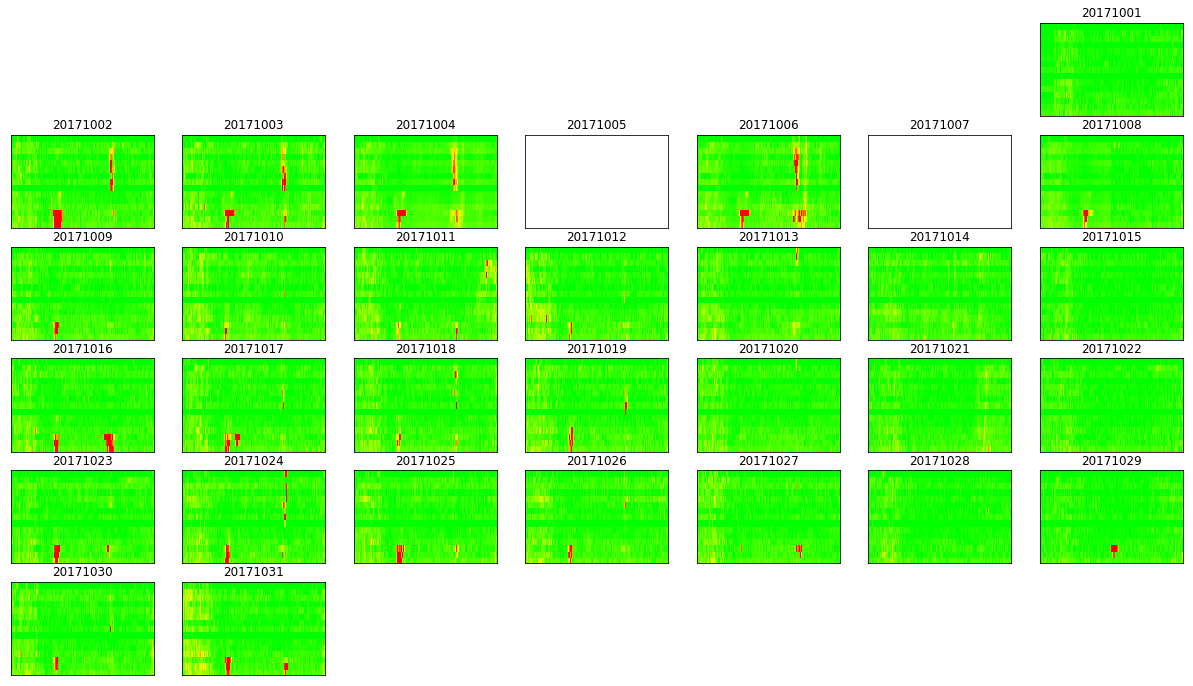

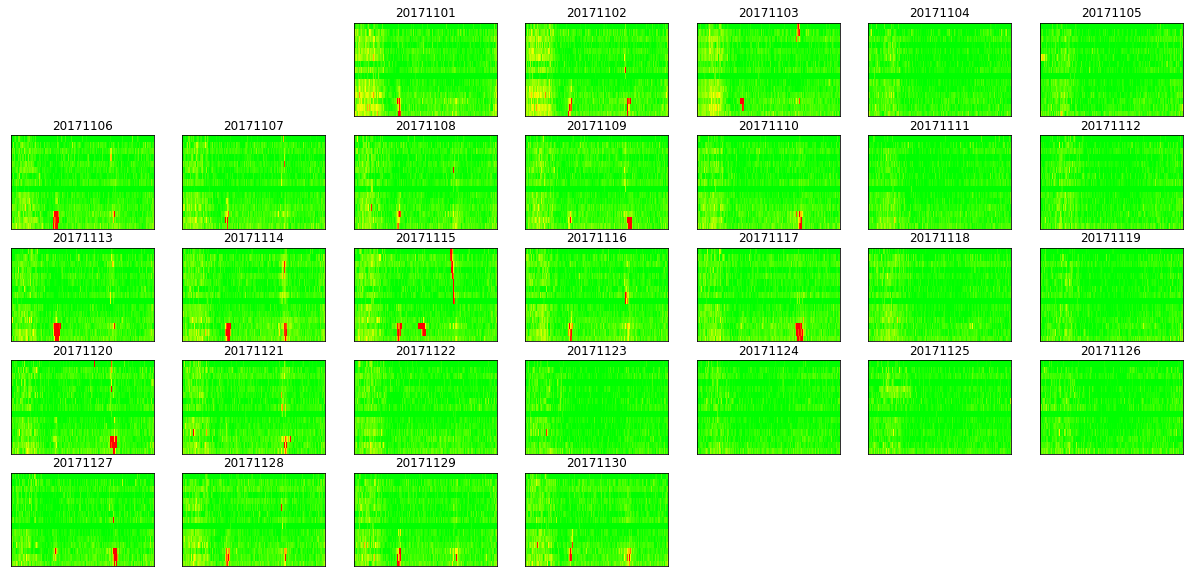

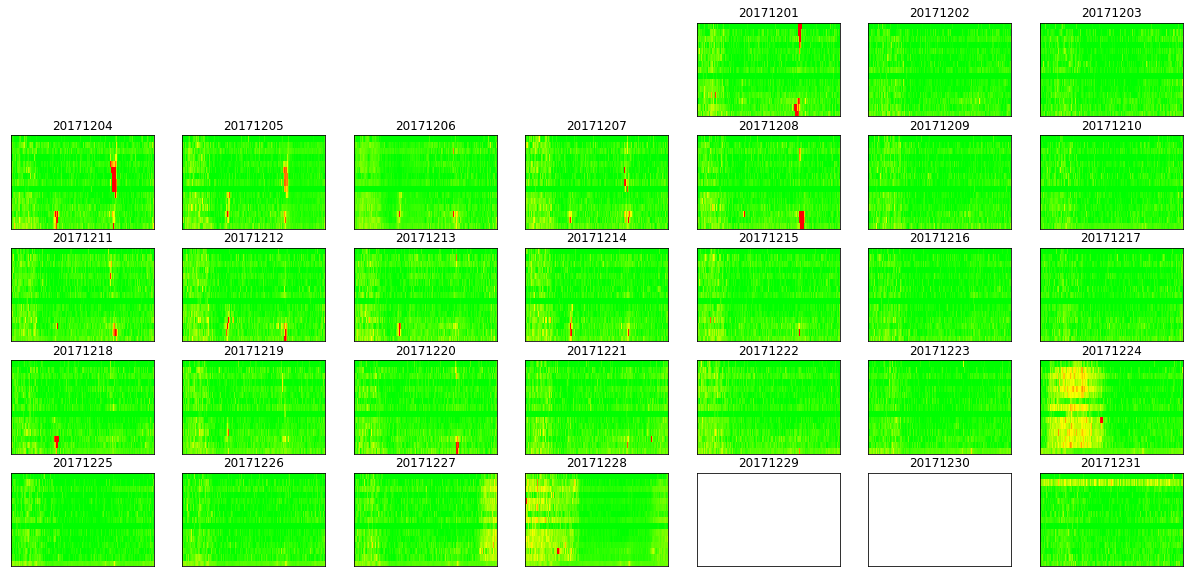

In [9]:
'''Annual speed heatmap plot'''

month = ['01','02','03','04','05','06','07','08','09','10','11','12']
dayend =['31','28','31','30','31','30','31','31','30','31','30','31']
if int(year)%4 == 0:
    dayend =['31','29','31','30','31','30','31','31','30','31','30','31']
    
for i in range(12):
    fig = monthly_plot(month[i],dayend[i])
    fig.savefig('../data/'+year+'_smoothed/'+month[i]+'_smoothed.png')

from fpdf import FPDF
pdf = FPDF()
# imagelist is the list with all image filenames
imagelist = os.listdir('../data/'+year+'_smoothed/')
for image in imagelist:
    pdf.add_page(orientation = 'L')
    pdf.image('../data/'+year+'_smoothed/'+image,-30,0,350,180)
pdf.output('../data/'+year+'_smoothed.pdf', "F")

In [11]:
def moving_avg_batch(data,window_length=5):
    data_new = np.zeros(data.shape)
    for i in range(window_length):
        data_shift = np.copy(data)
        data_shift[:,:,i:]=data[:,:,:data.shape[2]-i]
        data_new += data_shift
    return data_new/window_length

def data_smoothing_moving_avg(data,window_length=5):
    data_new = np.copy(data)
    if len(data.shape)==4:
        for i in range(data.shape[-1]):
            data_new[:,:,:,i] = moving_avg_batch(data[:,:,:,i],window_length=window_length)
    if len(data.shape)==3:
        data_new = moving_avg_batch(data,window_length=window_length)
    return data_new

In [12]:
Traffic = data_smoothing_moving_avg(Traffic)

weeks_in_month:  6
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  6
weeks_in_month:  5
weeks_in_month:  5
weeks_in_month:  6
weeks_in_month:  5
weeks_in_month:  5


''

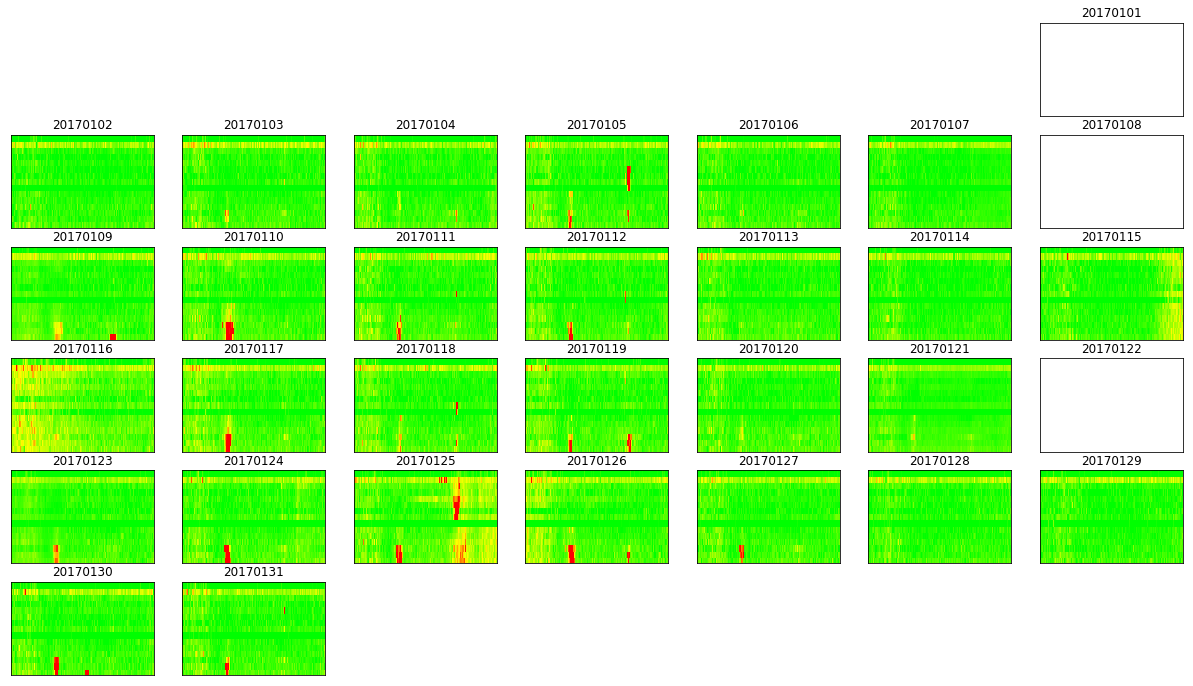

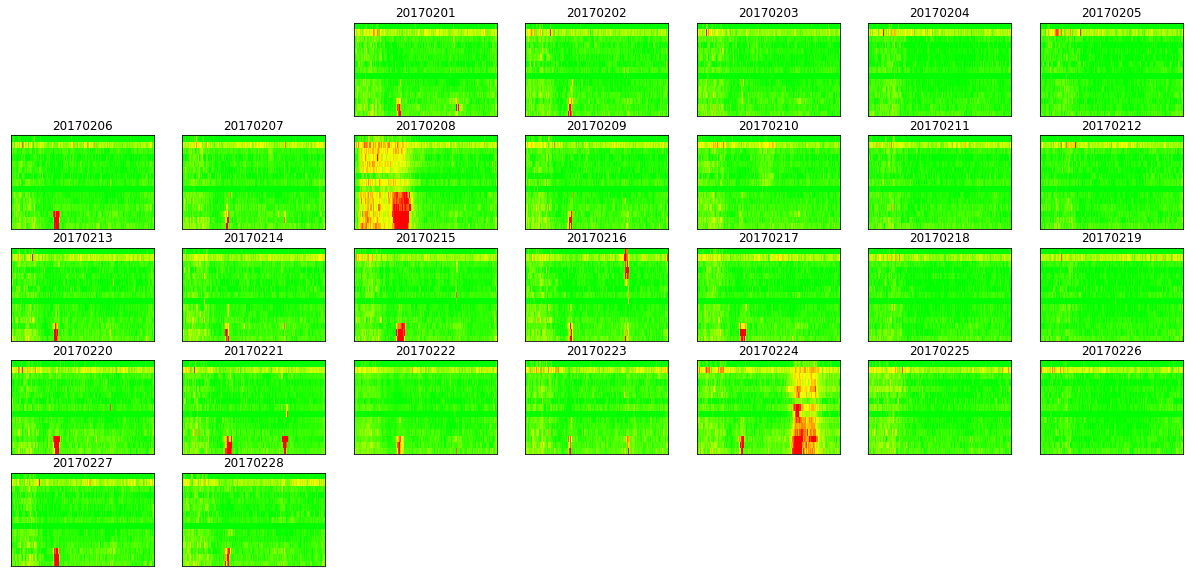

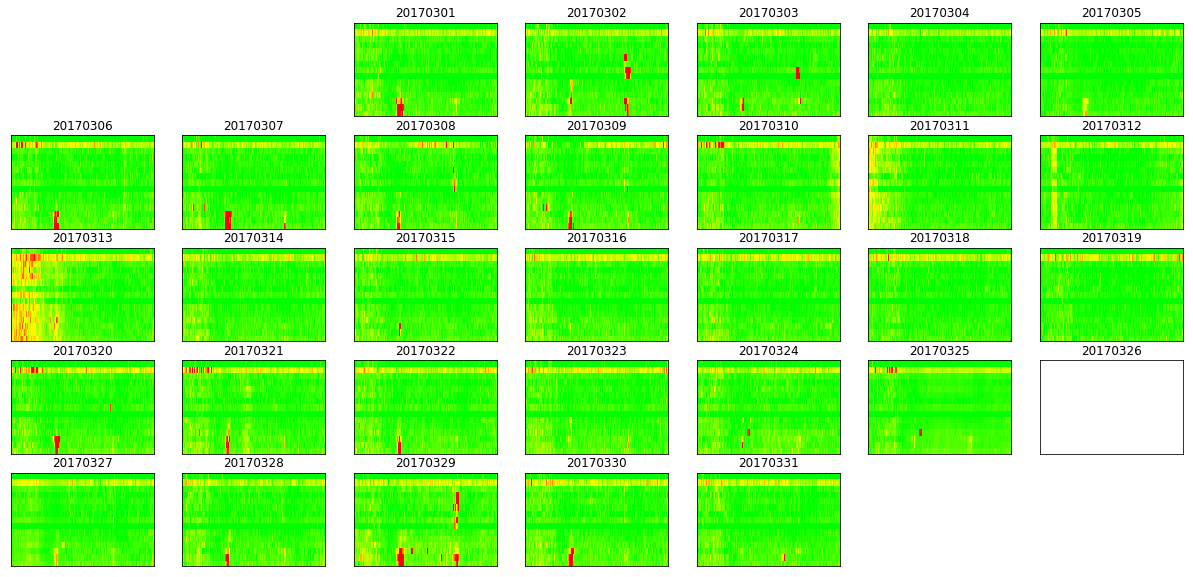

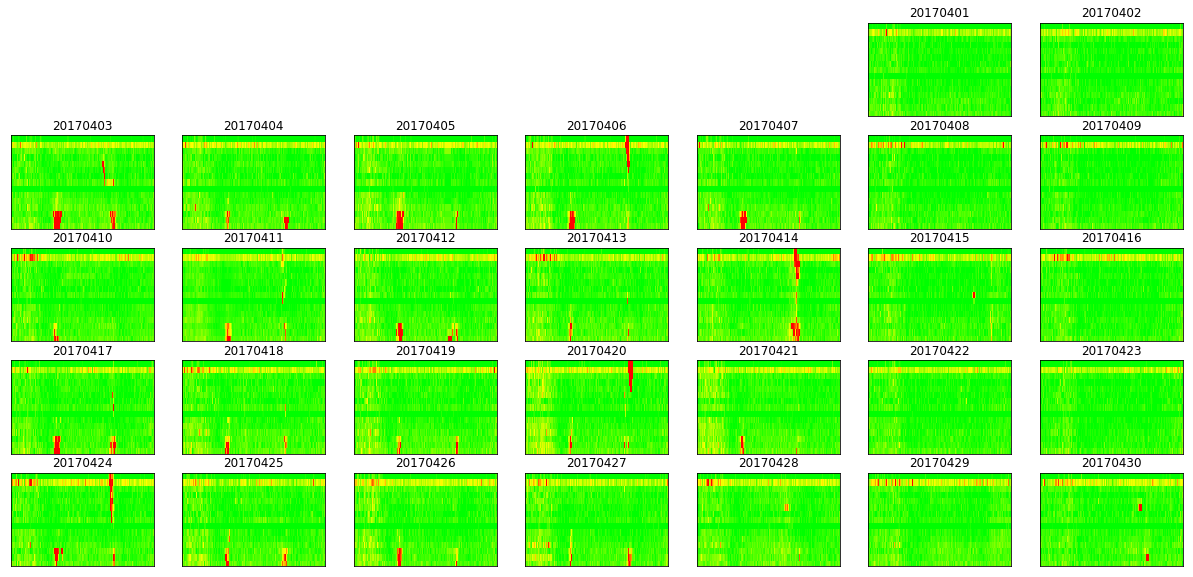

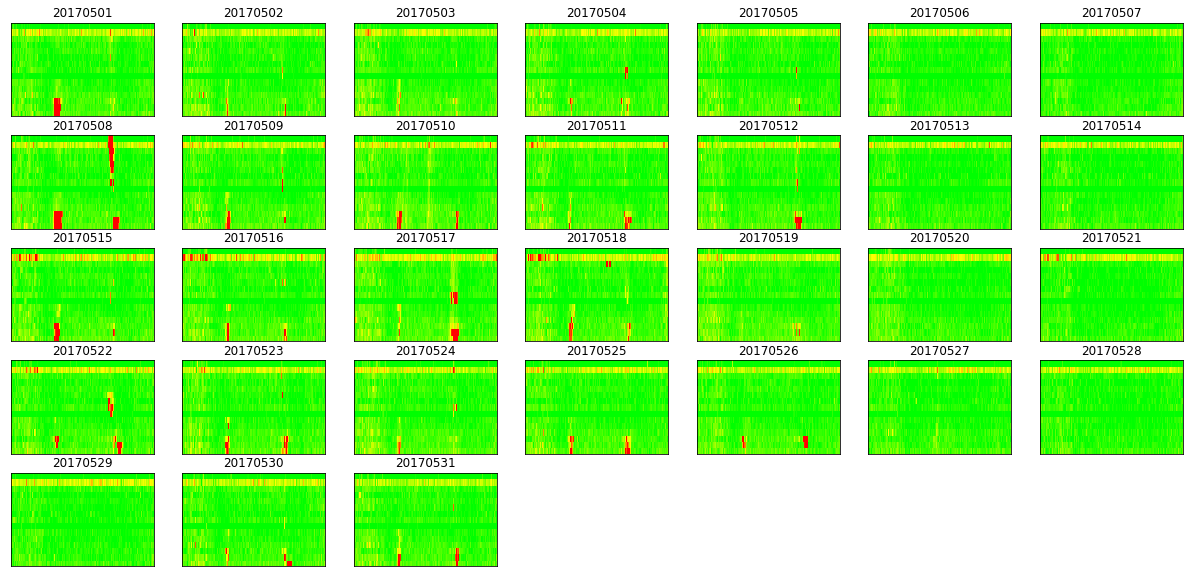

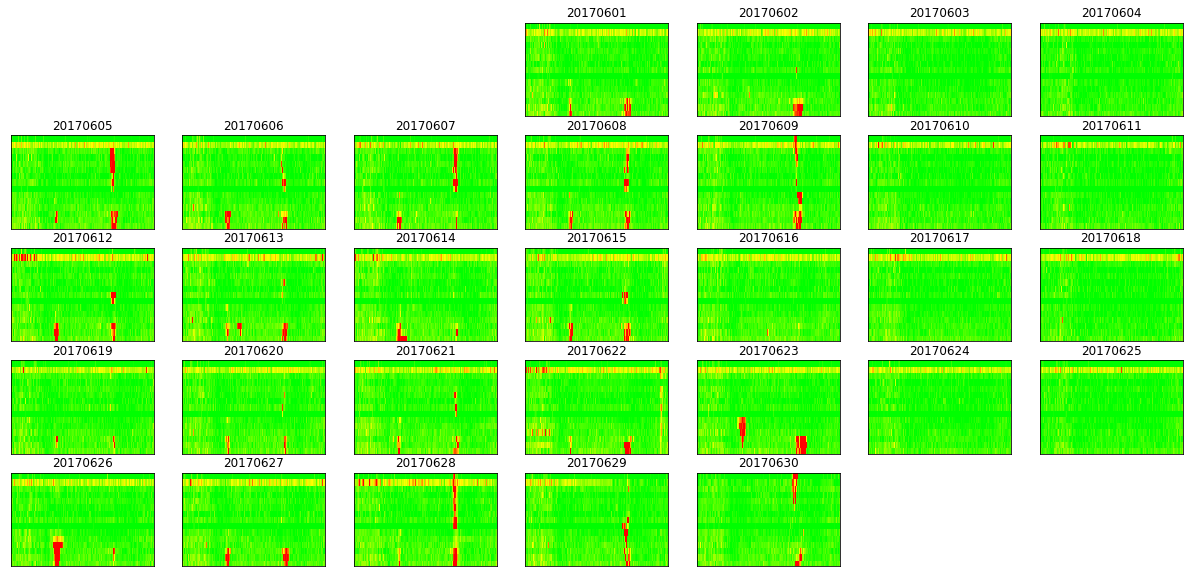

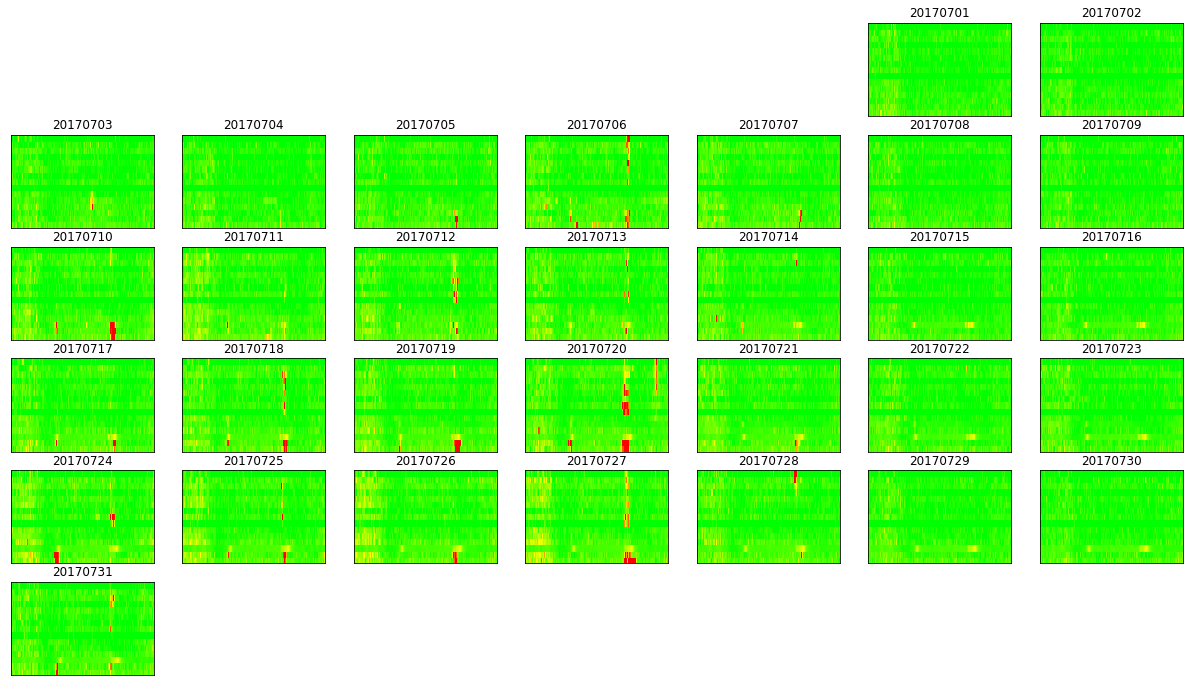

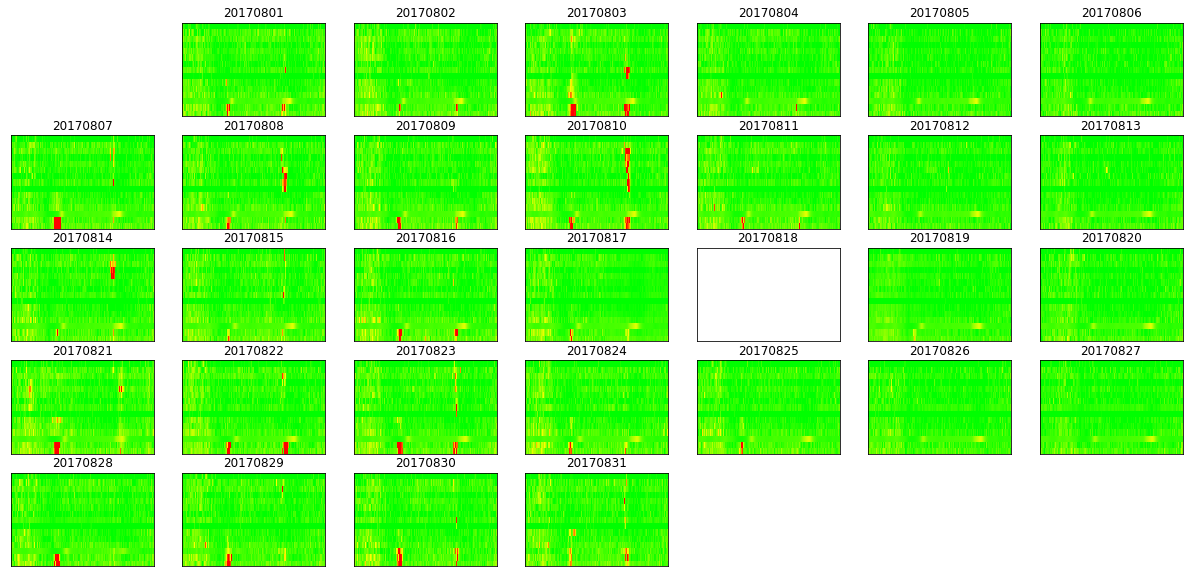

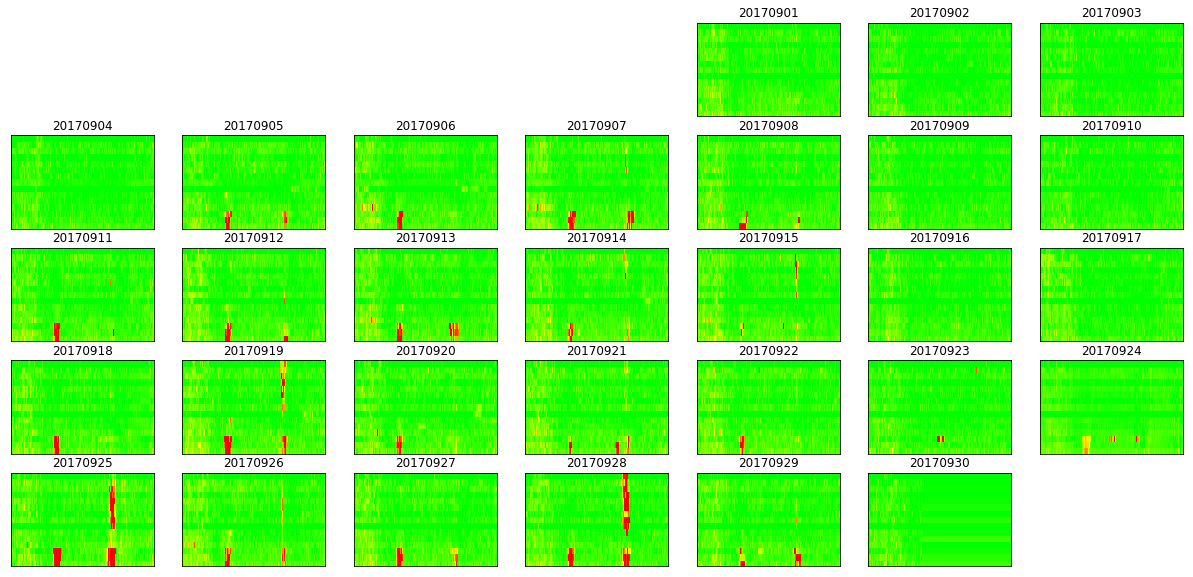

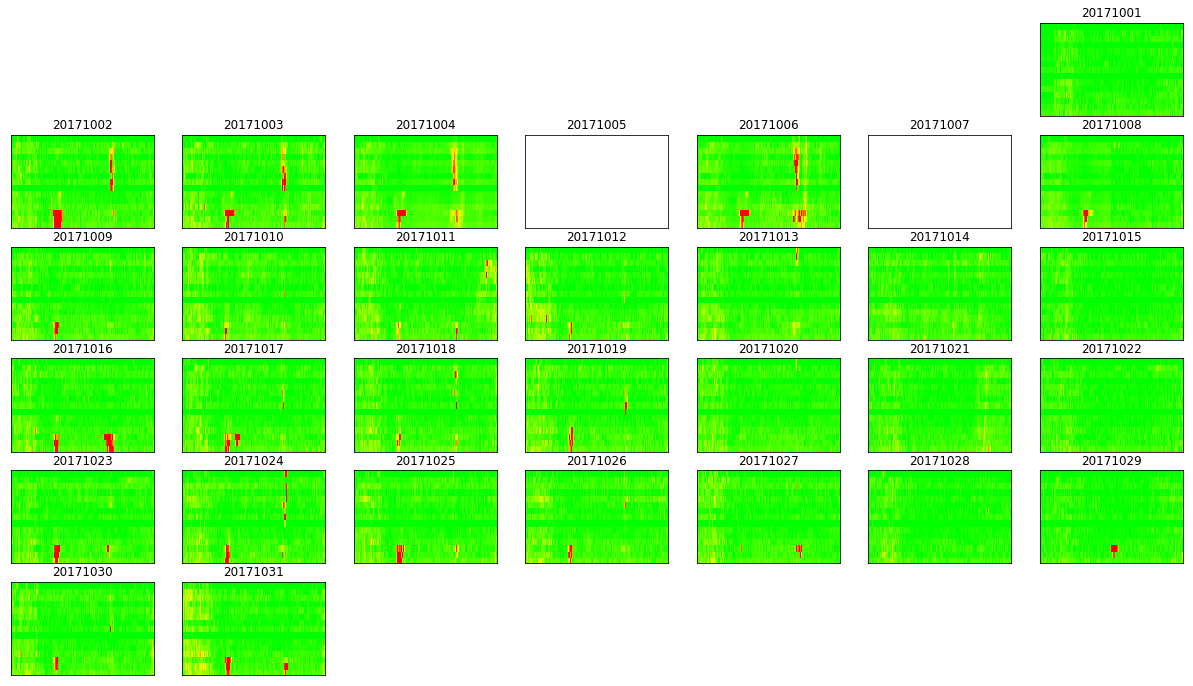

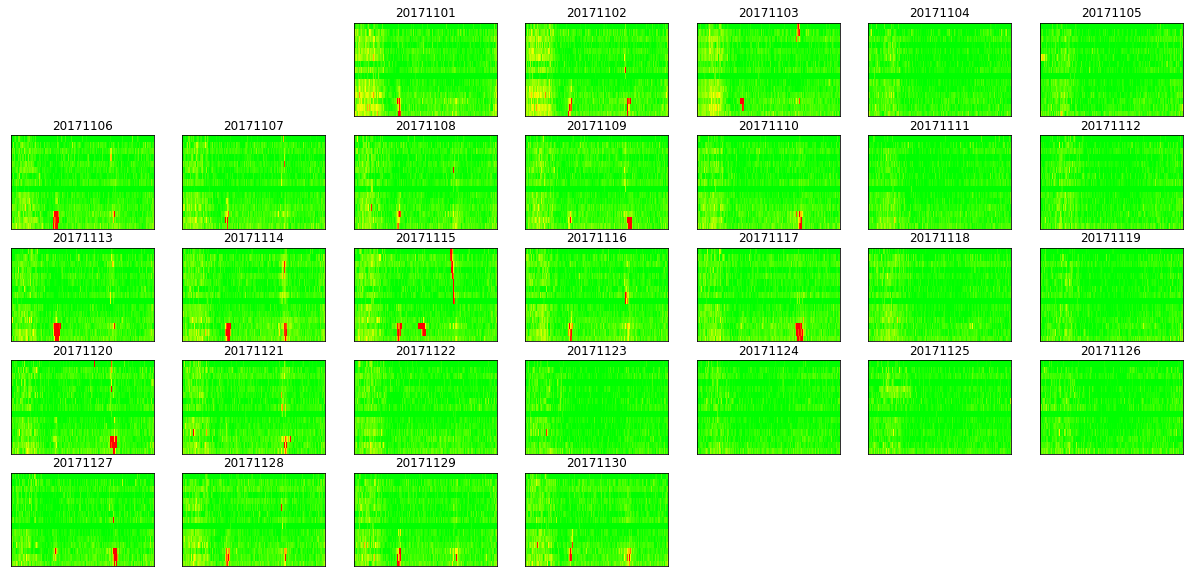

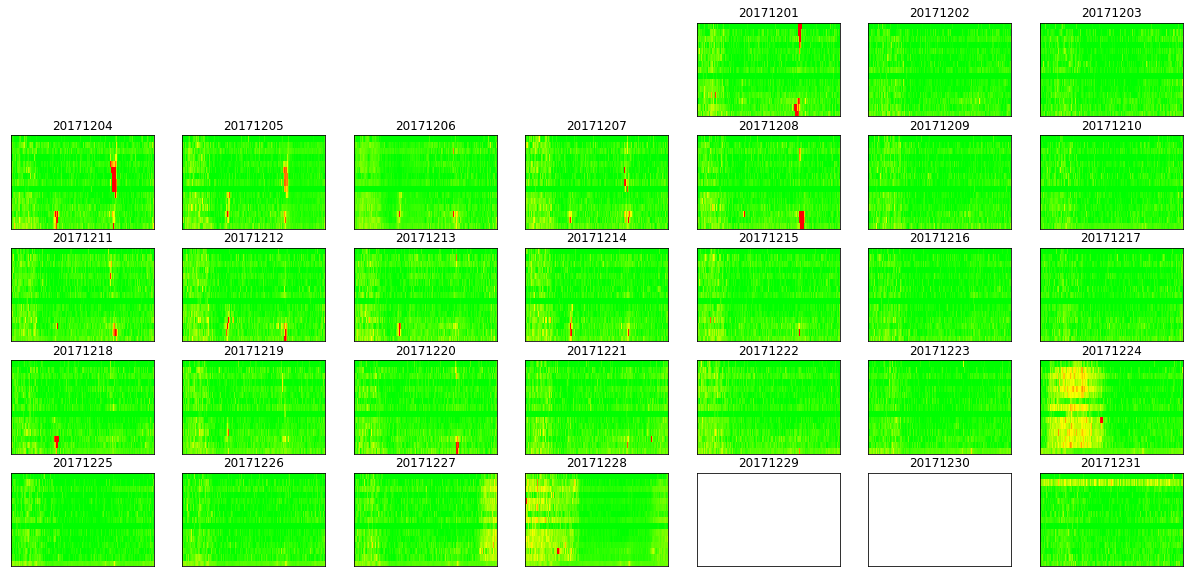

In [13]:
'''Annual speed heatmap plot'''

month = ['01','02','03','04','05','06','07','08','09','10','11','12']
dayend =['31','28','31','30','31','30','31','31','30','31','30','31']
if int(year)%4 == 0:
    dayend =['31','29','31','30','31','30','31','31','30','31','30','31']
    
for i in range(12):
    fig = monthly_plot(month[i],dayend[i])
    fig.savefig('../data/'+year+'_ma/'+month[i]+'_ma.png')

from fpdf import FPDF
pdf = FPDF()
# imagelist is the list with all image filenames
imagelist = os.listdir('../data/'+year+'_ma/')
for image in imagelist:
    pdf.add_page(orientation = 'L')
    pdf.image('../data/'+year+'_ma/'+image,-30,0,350,180)
pdf.output('../data/'+year+'_ma.pdf', "F")